In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report

In [3]:
data = pd.read_csv('credit_card_approval.csv')
# Remove the missing values
data = data.dropna()

# Drop the ID 
data.drop('ID', axis=1, inplace=True)

# Split the data into features and target
features = data.drop('TARGET', axis=1)
target = data['TARGET']

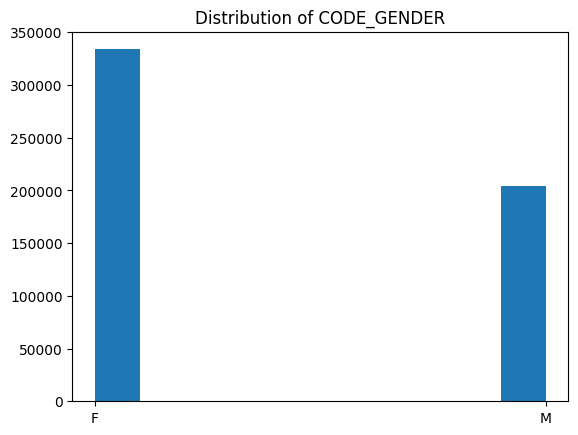

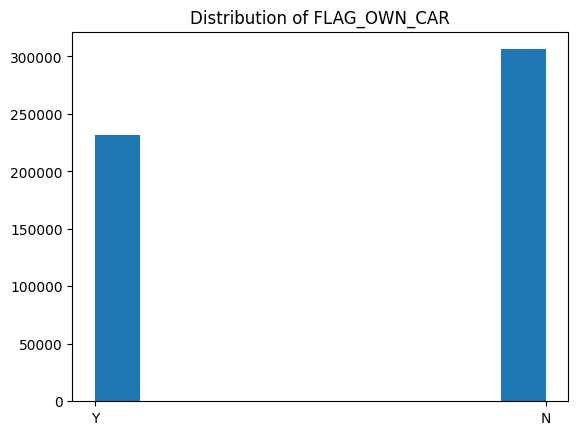

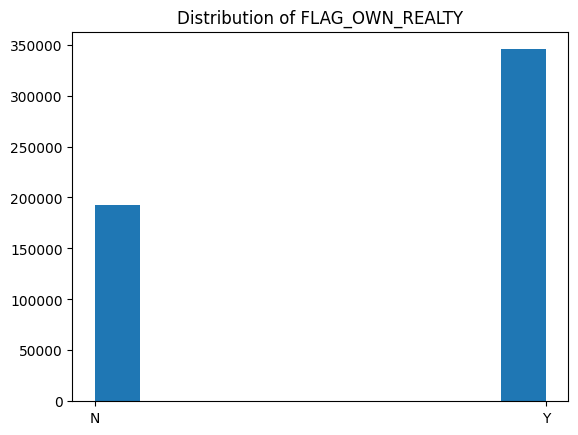

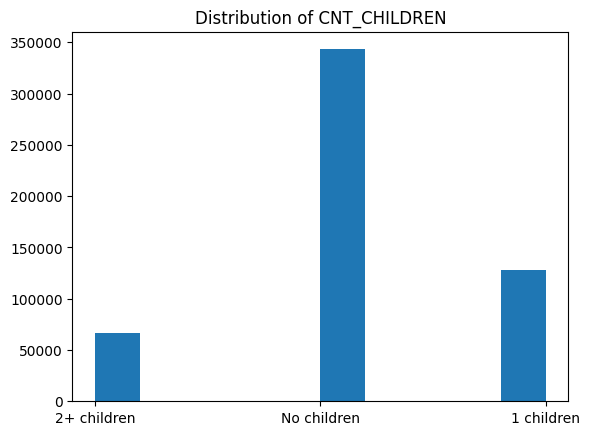

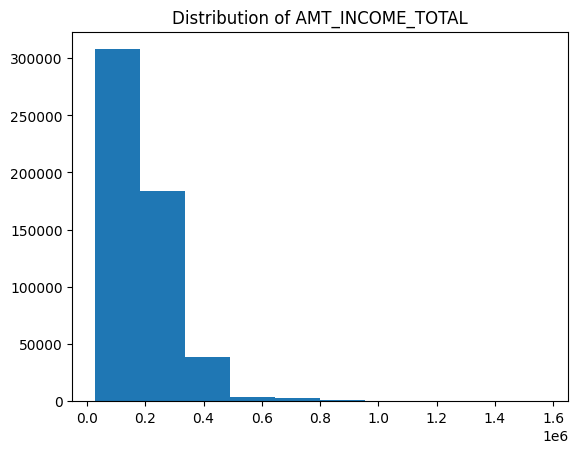

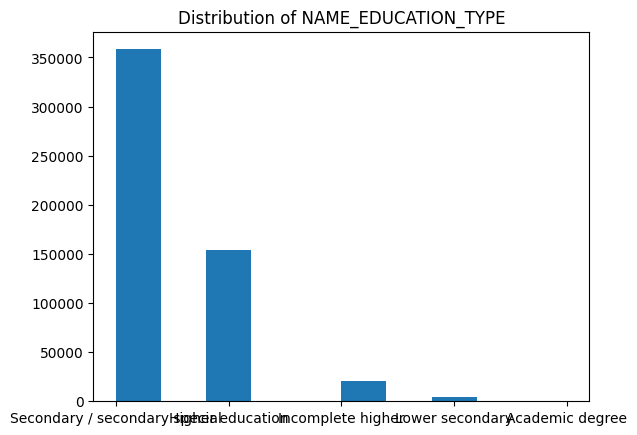

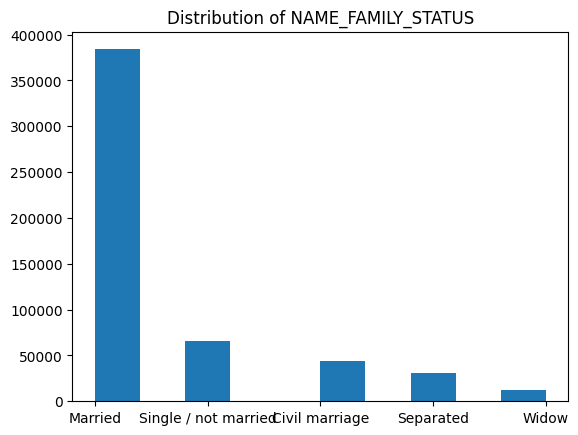

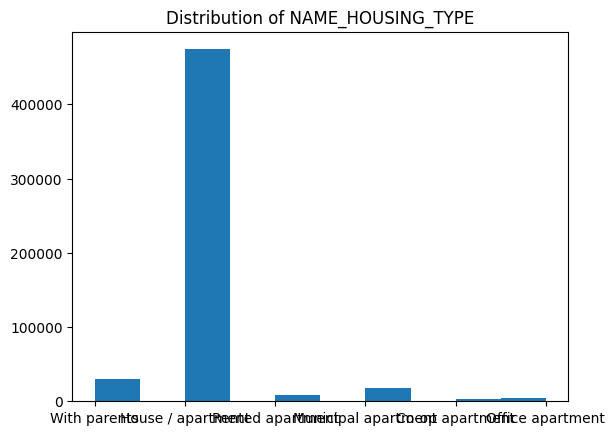

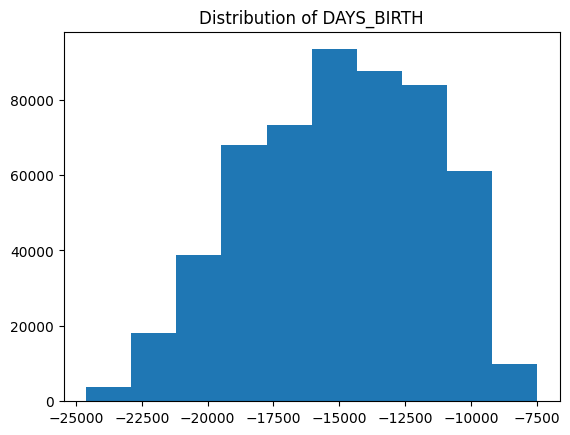

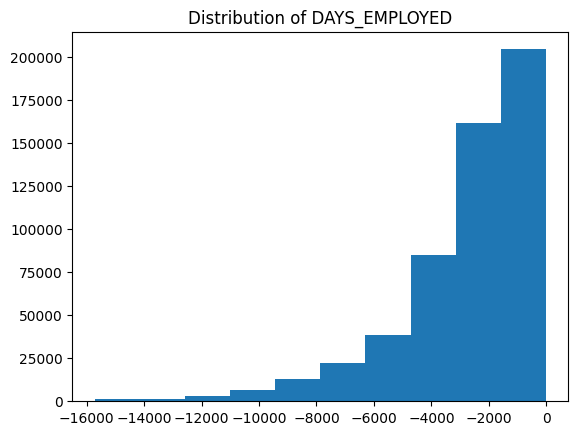

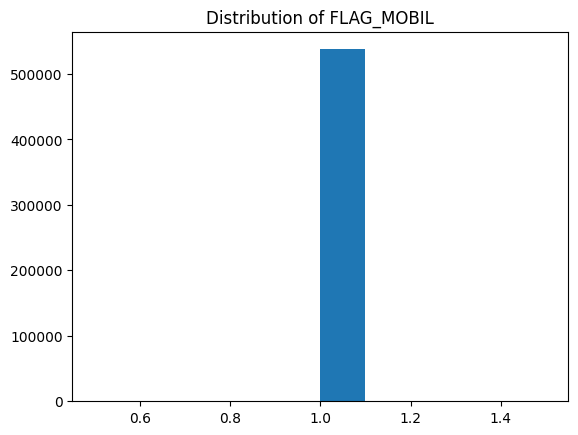

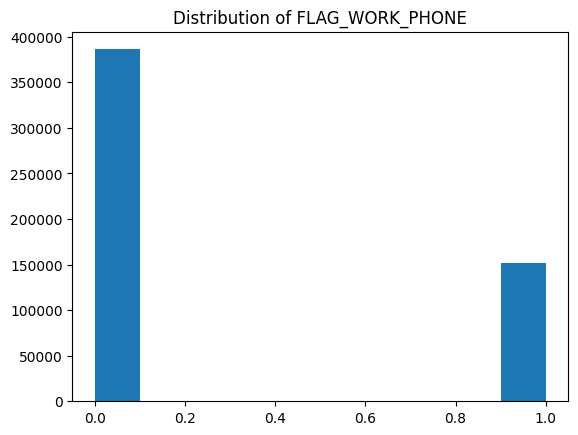

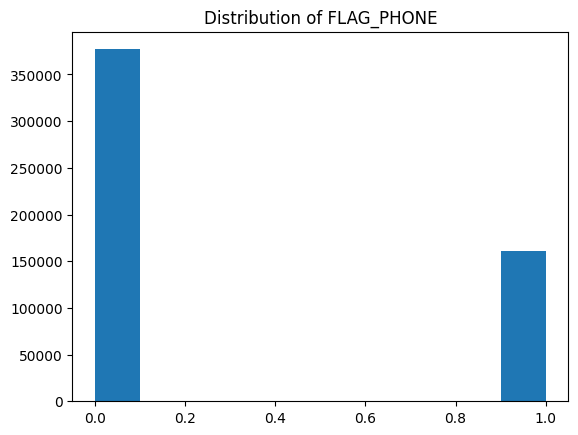

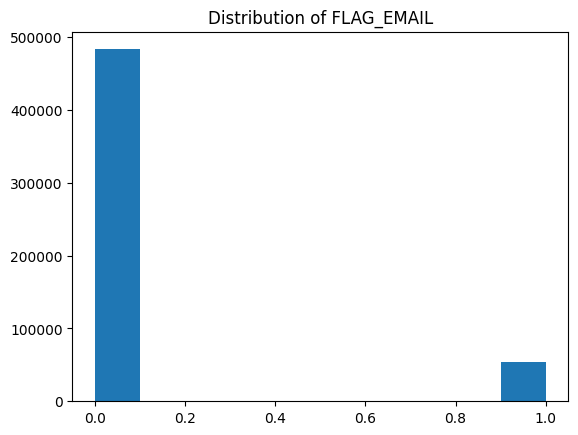

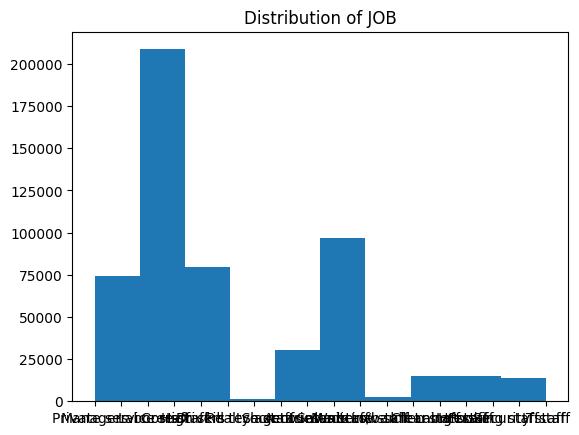

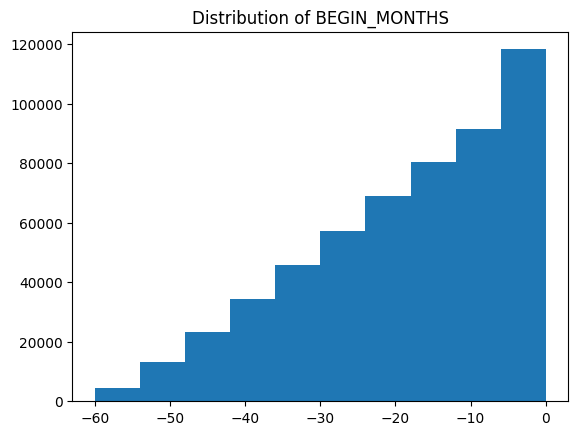

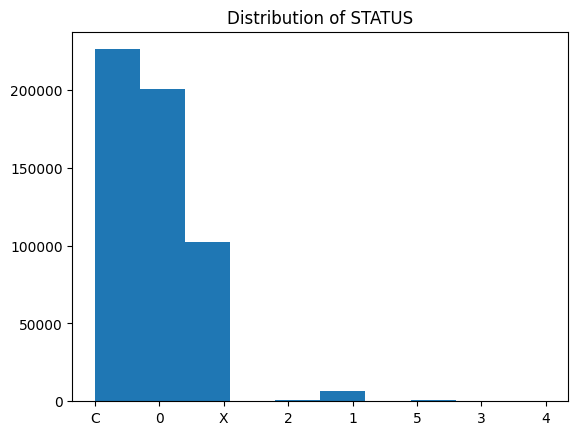

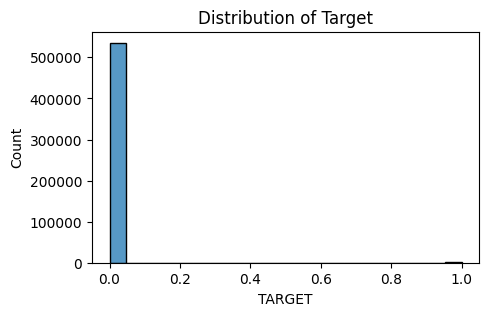

In [4]:
# Visualize the distribution of the features and target
for column in features.columns:
    plt.hist(features[column])
    plt.title(f'Distribution of {column}')
    plt.show()
plt.figure(figsize=(5, 3))
sns.histplot(target)
plt.title('Distribution of Target')
plt.show()



30 principal components that explain 80% of the variance.


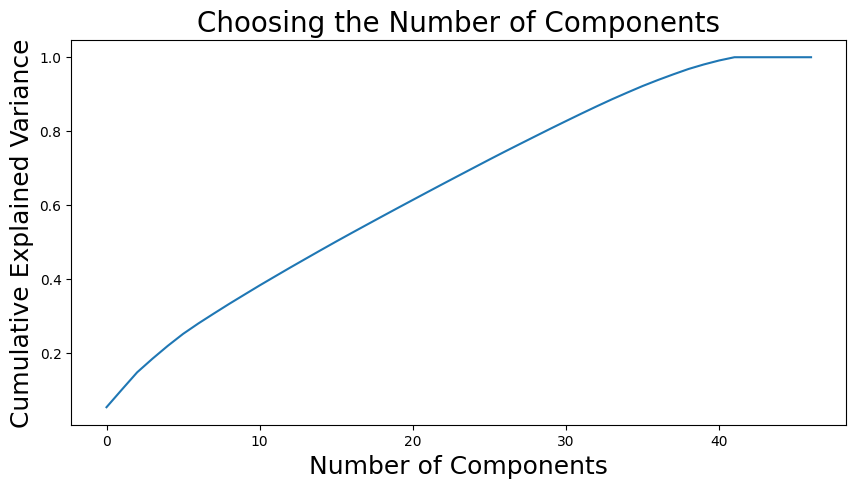

In [5]:


# print(data.head())

data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])
data['DAYS_EMPLOYED'] = abs(data['DAYS_EMPLOYED'])
data['BEGIN_MONTHS'] = abs(data['BEGIN_MONTHS'])


#  Encode the gender, flag_own_car columns and flag_own_realty, F as 1, M as 0, and Y as 1, N as 0.
data['CODE_GENDER'] = data['CODE_GENDER'].map({'F': 1, 'M': 0})
data['FLAG_OWN_CAR'] = data['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
data['FLAG_OWN_REALTY'] = data['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})


# Preprocess the children column, replace "2+ Children" with 2, "1 Child" with 1, and "No Children" with 0.
def process_children(x):
    if 'No children' in x:
        return 0
    elif '1 children' in x:
        return 1
    elif '2+ children' in x:
        return 2  
    
    else:
        return None 
data['CNT_CHILDREN'] = data['CNT_CHILDREN'].apply(process_children)

# One-hot encode the columns NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, and JOB.
data = pd.get_dummies(data, columns=['NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'JOB'])

# Defite status
status_mapping = {
    '0': 1,   # 1-29 days past due
    '1': 2,   # 30-59 days past due
    '2': 3,   # 60-89 days overdue
    '3': 4,   # 90-119 days overdue
    '4': 5,   # 120-149 days overdue
    '5': 6,   # Overdue or bad debts, write-offs for more than 150 days
    'C': 0,   # paid off that month
    'X': -1   # No loan for the month
}

data['STATUS'] = data['STATUS'].map(status_mapping)


# Split the data into features and target
features = data.drop('TARGET', axis=1)
target = data['TARGET']

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA()
pca.fit(X_train)
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components',fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
ax.set_title('Choosing the Number of Components',fontsize=20)
# Determine the number of principal components that explain 80% of the variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.8) + 1
print(f'{n_components} principal components that explain 80% of the variance.')

# Apply PCA to the data
pca = PCA(n_components=n_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)





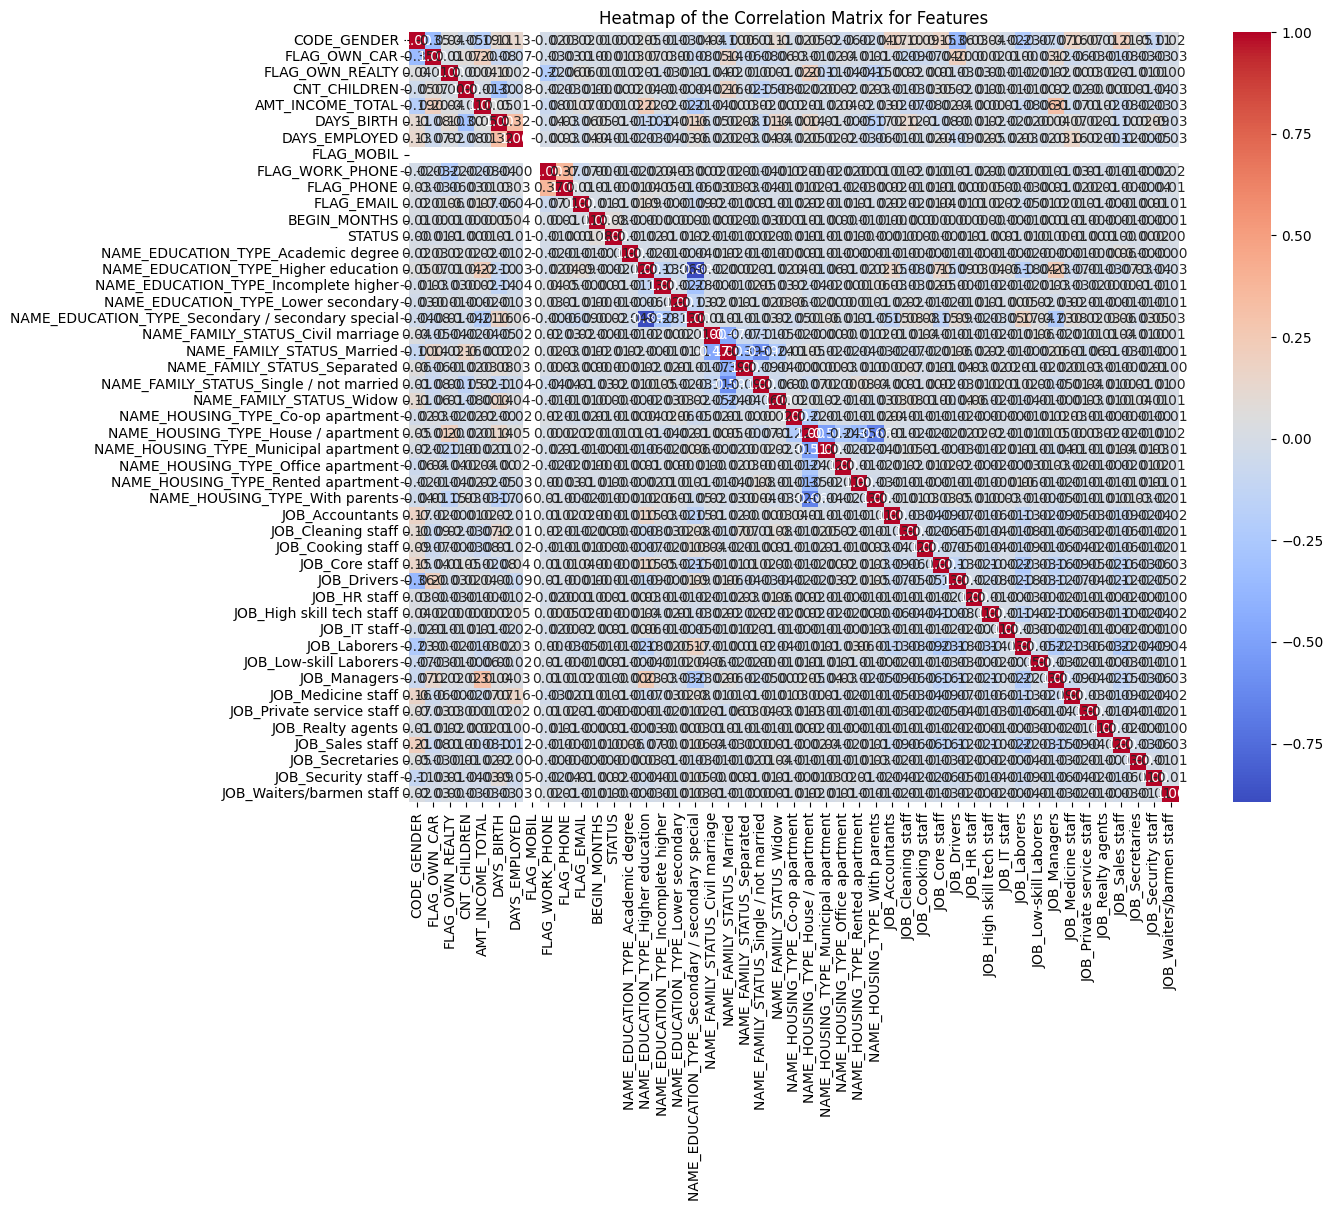

In [12]:
# Heatmap of the correlation matrix
correlation_matrix = features.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Heatmap of the Correlation Matrix for Features')
plt.show()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def train_model(learning_rate, batch_size,n_units):
    model = Sequential([
        Dense(n_units, input_shape=(n_components,), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_split=0.2, 
                        epochs=2, batch_size=batch_size, verbose=0)
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy


learning_rates = [1e-2, 1e-3, 1e-4]
best_lr = learning_rates[0]
best_accuracy = 0

for lr in learning_rates:
    accuracy = train_model(lr, batch_size=32,n_units=32)  
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lr = lr

print(f"Best learning rate: {best_lr}")


batch_sizes = [16, 32, 64]
best_batch_size = batch_sizes[0]

for bs in batch_sizes:
    accuracy = train_model(best_lr, bs,n_units=32)  
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_batch_size = bs

print(f"Best batch size: {best_batch_size}")

n_units = [32, 64, 128]
best_n_units = n_units[0]

for nu in n_units:
    accuracy = train_model(best_lr, best_batch_size,nu)  
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_units = nu

print(f"Best n units: {best_n_units}")

print(f'Test Accuracy: {best_accuracy*100:.2f}%')

c:\Users\23347\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best learning rate: 0.001
Best batch size: 16
Best n units: 128
Test Accuracy: 99.96%
